# EDA   explosive data analysis

In [0]:
import pandas as pd
labels = pd.read_csv('labels.csv')

In [0]:
n = len(labels)
breed = set(labels['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
n_class = len(breed)

In [0]:
labels.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [0]:
yy = pd.value_counts(labels['breed'])
print(yy[:10])

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
Name: breed, dtype: int64


In [0]:
print(yy[-10:])

otterhound           69
giant_schnauzer      69
tibetan_mastiff      69
german_shepherd      69
walker_hound         69
golden_retriever     67
komondor             67
brabancon_griffon    67
eskimo_dog           66
briard               66
Name: breed, dtype: int64


Text(0.5, 1.0, 'Distribution of the Dog Breeds')

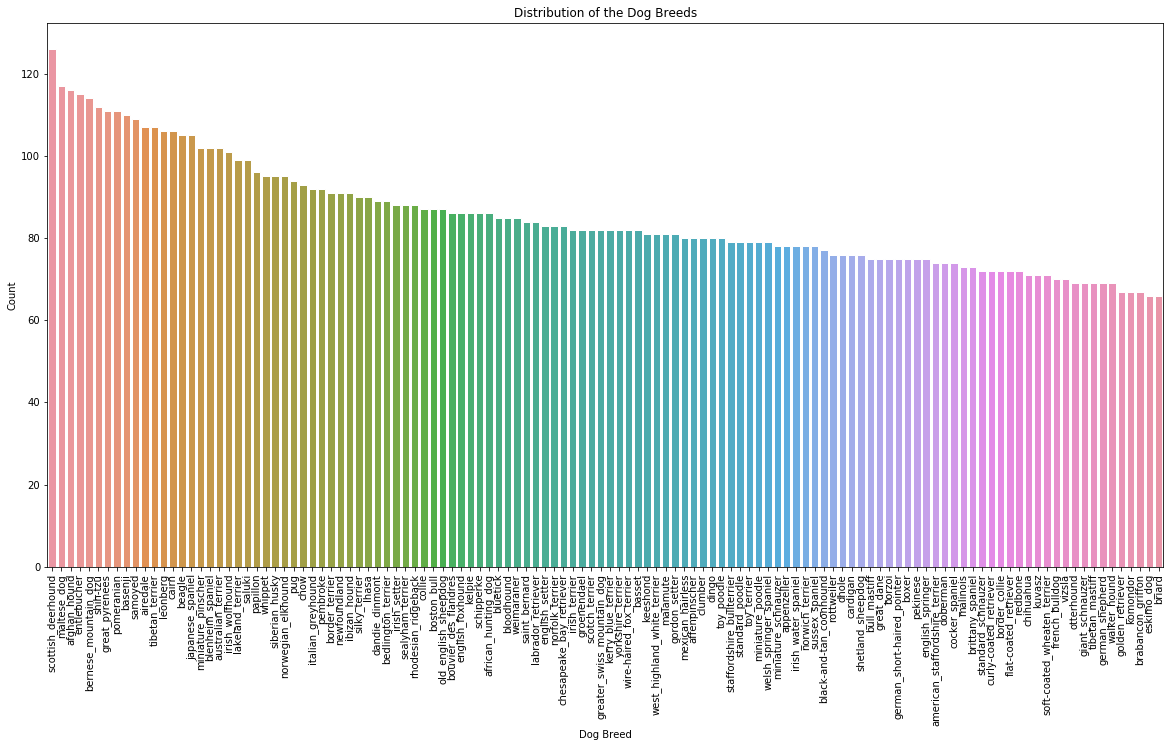

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.set_style("whitegrid")

ax = sns.barplot(x = yy.index, y = yy, data = labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 10)
ax.set(xlabel='Dog Breed', ylabel='Count')
ax.set_title('Distribution of the Dog Breeds')

# Resize the data to be three new data set as 120 * 20, 120 * 40 and 120 * 60

In [0]:
!mkdir images120_20
!mkdir images120_40
!mkdir images120_60

In [0]:
import os, random, shutil

for dir in os.listdir('Images/'):
    os.mkdir('images120_20/'+dir)
    os.mkdir('images120_40/'+dir)
    os.mkdir('images120_60/'+dir)

In [0]:
# ramdomly select 20/ 40 / 60 from the original dataset of 120 do breeds

for dir in os.listdir('Images/'):
    filepath = 'Images/' + dir + '/'
    tarDir = 'images120_20/' + dir + '/'
    
    files = os.listdir(filepath)
    sample = random.sample(files, 20)
    
    for name in sample:
        shutil.copy(filepath+name, tarDir+name)

In [0]:
# ramdomly select 20/ 40 / 60 from the original dataset of 120 do breeds

for dir in os.listdir('Images/'):
    filepath = 'Images/' + dir + '/'
    tarDir = 'images120_40/' + dir + '/'
    
    files = os.listdir(filepath)
    sample = random.sample(files, 40)
    
    for name in sample:
        shutil.copy(filepath+name, tarDir+name)

In [0]:
# ramdomly select 20/ 40 / 60 from the original dataset of 120 do breeds

for dir in os.listdir('Images/'):
    filepath = 'Images/' + dir + '/'
    tarDir = 'images120_60/' + dir + '/'
    
    files = os.listdir(filepath)
    sample = random.sample(files, 60)
    
    for name in sample:
        shutil.copy(filepath+name, tarDir+name)

In [0]:
!mkdir images120_60_train
!mkdir images120_60_val
!mkdir images120_60_test

In [0]:
for dir in os.listdir('Images/'):
    os.mkdir('images120_60_train/'+dir)
    os.mkdir('images120_60_test/'+dir)
    os.mkdir('images120_60_val/'+dir)

In [0]:
for dir in os.listdir('Images/'):
    filepath = 'Images/' + dir + '/'
    files = os.listdir(filepath)
    sample = random.sample(files, 60)
    
    tarDir = 'images120_60_train/' + dir + '/'
    for name in sample[:40]:
      shutil.copy(filepath+name, tarDir+name)

    tarDir = 'images120_60_val/' + dir + '/'
    for name in sample[40:50]:    
      shutil.copy(filepath+name, tarDir+name)
      
    tarDir = 'images120_60_test/' + dir + '/'
    for name in sample[50:]:
      
      shutil.copy(filepath+name, tarDir+name)

# training process starts from here

# Pytorch

In [5]:
from __future__ import print_function, division

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
])
}

In [8]:
# Set the directory for the data
data_dir = 'images120_60_'

# Use the image folder function to create datasets
dog_datasets = {x: datasets.ImageFolder(data_dir+x+'/',
  chosen_transforms[x]) for x in ['train', 'val', 'test']} 

In [9]:
dataloaders = {x: DataLoader(dataset=dog_datasets[x], batch_size=8, shuffle=True, num_workers=4)
  for x in ['train','val','test']}

In [10]:
dataset_sizes = {x: len(dog_datasets[x]) for x in ['train','val','test']}
class_names = dog_datasets['train'].classes
print(dataset_sizes)
print(len(class_names))

{'train': 4800, 'val': 1200, 'test': 1200}
120


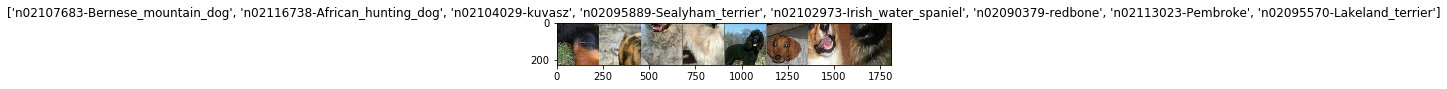

In [11]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Grab some of the training data to visualize
inputs, classes = next(iter(dataloaders['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
LOG_DIR = 'log/'
def train_model(model, criterion, optimizer, num_epochs=10, log_file_name='log'):
    log_file = open(LOG_DIR + log_file_name, 'w')
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                # scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            # print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                  loss.backward()
                  optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item()# * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            outline = f'{epoch} {epoch_loss:.4f} {epoch_acc:.4f} {phase}\n'
            log_file.write(outline)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    log_file.close()
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [13]:
def evaluate_model(model, log_file_name='log'):

  phase = 'test'
  log_file = open(LOG_DIR + log_file_name, 'a')
  model.eval()   # Set model to evaluate mode

  current_loss = 0.0
  current_corrects = 0

  for inputs, labels in dataloaders[phase]:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)


      # We want variables to hold the loss statistics
      current_loss += loss.item()# * inputs.size(0)
      current_corrects += torch.sum(preds == labels.data)

  epoch_loss = current_loss / dataset_sizes[phase]
  epoch_acc = current_corrects.double() / dataset_sizes[phase]

  outline = f'{phase} {epoch_loss:.4f} {epoch_acc:.4f} {phase}\n'
  log_file.write(outline)
  log_file.close()

  print('{} Loss: {:.4f} Acc: {:.4f}'.format(
      phase, epoch_loss, epoch_acc))


# Model 1-- CNN

In [14]:
import torch.nn.functional as F

n_classes = 120

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1 )        
        # convolutional layer (sees 112x112x16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        # convolutional layer (sees 56x56x32 image tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        # convolutional layer (sees 28x28x64 image tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)        
        # convolutional layer (sees 14x14x128 image tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1 )
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)
        
        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)
        
        # linear layer (256 * 7 * 7 -> 512)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        # linear layer (256 * 7 * 7 -> n_classes (133))
        self.fc2 = nn.Linear(512, n_classes)
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv_bn2(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv_bn3(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv_bn4(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.conv_bn5(x)
        x = self.pool(F.relu(self.conv5(x)))
        x = self.conv_bn6(x)
        
        # flatten image input
        x = x.view(-1, 256 * 7 * 7)        
        # add dropout layer
        x = self.dropout(x)
        # add second hidden layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
cnn = Net()
cnn = cnn.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer_ft = optim.SGD(cnn.parameters(), lr=0.00001, momentum=0.9)

cnn_best = train_model(cnn, criterion, optimizer_ft,num_epochs=10,
                       log_file_name='cnn_60_0dot00001')

print('-' * 10)
evaluate_model(cnn_best, log_file_name='cnn_60_0dot00001')

Epoch 0/9
----------
train Loss: 0.6043 Acc: 0.0075
val Loss: 0.6044 Acc: 0.0067

Epoch 1/9
----------
train Loss: 0.6025 Acc: 0.0121
val Loss: 0.6017 Acc: 0.0067

Epoch 2/9
----------
train Loss: 0.6007 Acc: 0.0085
val Loss: 0.5995 Acc: 0.0075

Epoch 3/9
----------
train Loss: 0.5989 Acc: 0.0138
val Loss: 0.5979 Acc: 0.0117

Epoch 4/9
----------
train Loss: 0.5985 Acc: 0.0158
val Loss: 0.5959 Acc: 0.0100

Epoch 5/9
----------
train Loss: 0.5965 Acc: 0.0158


# Model2: Resnet34

In [0]:
resnet = models.resnet34(pretrained=True)
# for param in resnet.parameters():
#   param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 120)

# lr = [0.001, 0.0001, 0.00001]
# log_file_name = ['resnet_40_0dot001', 'resnet_40_0dot0001', 'resnet_40_0dot00001']

resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer_ft = optim.SGD(resnet.parameters(), lr=0.0001, momentum=0.9)

resnet_best = train_model(resnet, criterion, optimizer_ft, 
              num_epochs=20, log_file_name='resnet_60_0dot0001')

print('-' * 10)
evaluate_model(resnet_best, log_file_name='resnet_60_0dot0001')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth



Epoch 0/19
----------
train Loss: 0.6009 Acc: 0.0204
val Loss: 0.5626 Acc: 0.0483

Epoch 1/19
----------
train Loss: 0.5658 Acc: 0.0577
val Loss: 0.4914 Acc: 0.1733

Epoch 2/19
----------
train Loss: 0.5294 Acc: 0.1250
val Loss: 0.4136 Acc: 0.3217

Epoch 3/19
----------
train Loss: 0.4920 Acc: 0.1854
val Loss: 0.3448 Acc: 0.4467

Epoch 4/19
----------
train Loss: 0.4589 Acc: 0.2331
val Loss: 0.2832 Acc: 0.5400

Epoch 5/19
----------
train Loss: 0.4325 Acc: 0.2827
val Loss: 0.2421 Acc: 0.5883

Epoch 6/19
----------
train Loss: 0.4102 Acc: 0.2981
val Loss: 0.2087 Acc: 0.6267

Epoch 7/19
----------
train Loss: 0.3923 Acc: 0.3346
val Loss: 0.1833 Acc: 0.6592

Epoch 8/19
----------
train Loss: 0.3733 Acc: 0.3533
val Loss: 0.1707 Acc: 0.6775

Epoch 9/19
----------
train Loss: 0.3593 Acc: 0.3744
val Loss: 0.1581 Acc: 0.6917

Epoch 10/19
----------
train Loss: 0.3501 Acc: 0.3858
val Loss: 0.1418 Acc: 0.7150

Epoch 11/19
----------
train Loss: 0.3396 Acc: 0.3996
val Loss: 0.1371 Acc: 0.7258

E

In [0]:
def cm(model):
  nb_classes = 120

  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      classes = classes.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for t, p in zip(classes.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

  return confusion_matrix

cm_resnet = cm(resnet_best)
cm_resnet

tensor([[ 9.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  7.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 10.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., 10.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0., 10.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0., 10.]])

In [0]:
cm_resnet.shape

torch.Size([120, 120])

In [0]:
my_class_names = [x.split('-')[1] for x in class_names]
my_class_names

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Shih',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'black',
 'Walker_hound',
 'English_foxhound',
 'redbone',
 'borzoi',
 'Irish_wolfhound',
 'Italian_greyhound',
 'whippet',
 'Ibizan_hound',
 'Norwegian_elkhound',
 'otterhound',
 'Saluki',
 'Scottish_deerhound',
 'Weimaraner',
 'Staffordshire_bullterrier',
 'American_Staffordshire_terrier',
 'Bedlington_terrier',
 'Border_terrier',
 'Kerry_blue_terrier',
 'Irish_terrier',
 'Norfolk_terrier',
 'Norwich_terrier',
 'Yorkshire_terrier',
 'wire',
 'Lakeland_terrier',
 'Sealyham_terrier',
 'Airedale',
 'cairn',
 'Australian_terrier',
 'Dandie_Dinmont',
 'Boston_bull',
 'miniature_schnauzer',
 'giant_schnauzer',
 'standard_schnauzer',
 'Scotch_terrier',
 'Tibetan_terrier',
 'silky_terrier',
 'soft',
 'West_Highland_white_terrier',
 'Lhasa',
 'flat',
 'curly',
 'golden_retriever',


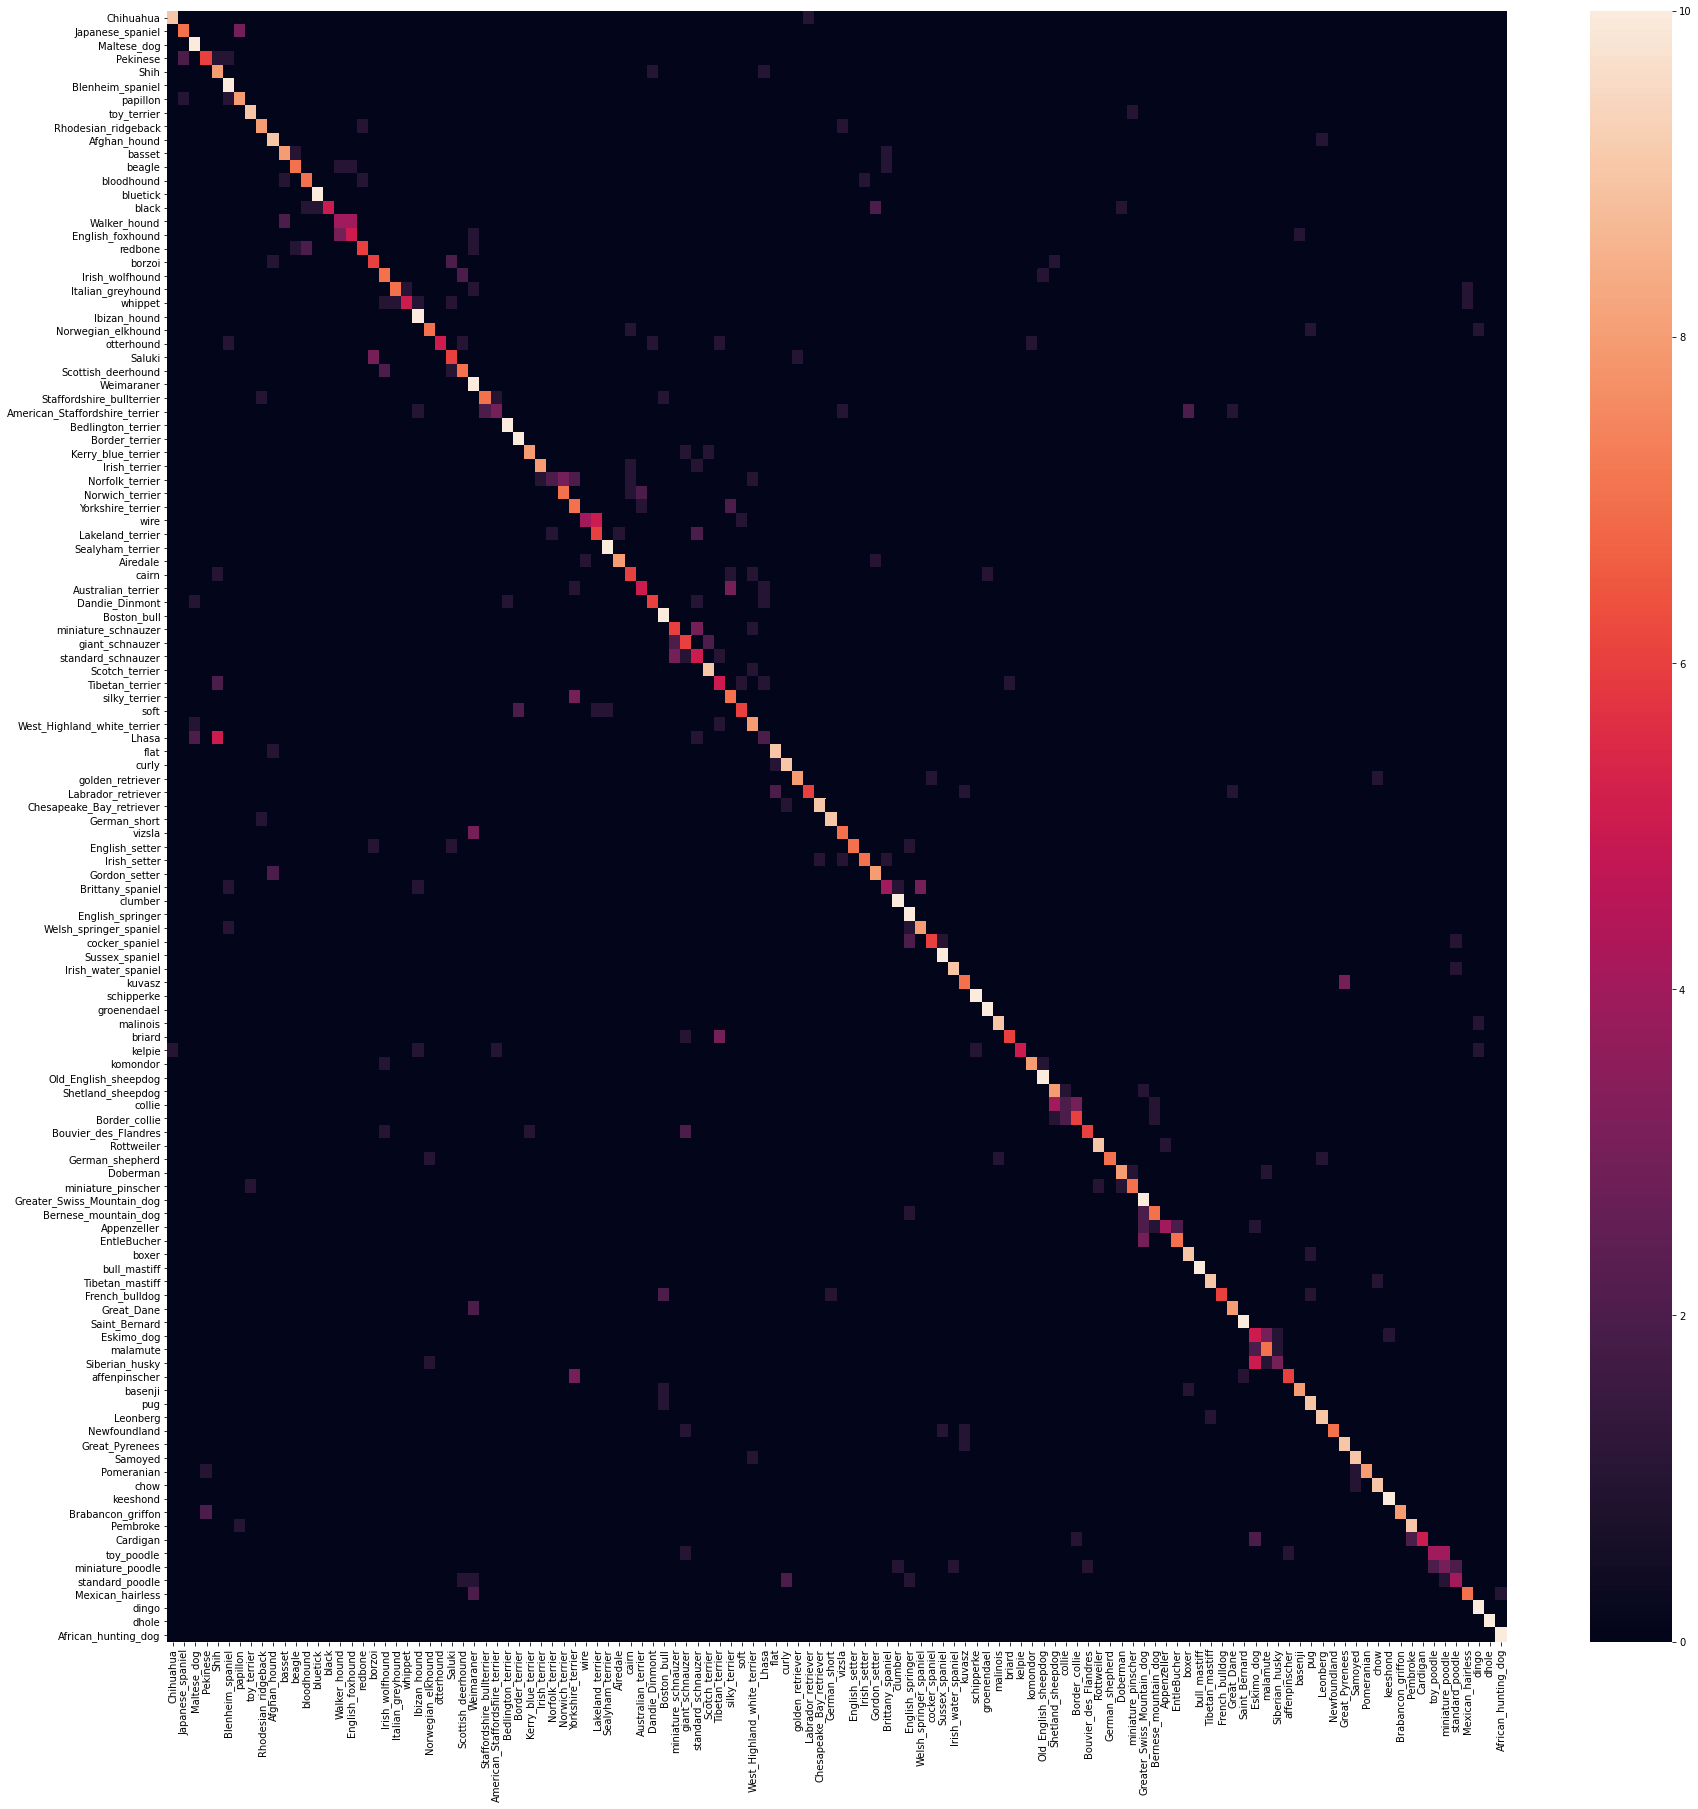

In [0]:
import seaborn as sn
import pandas as pd
# cm_resnet = cm(resnet_best)
df_cm = pd.DataFrame(cm_resnet.numpy(), index = [i for i in my_class_names],
                  columns = [i for i in my_class_names])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm)
plt.savefig('confusion_matrix')

# Model3:  VGG19

In [0]:
vgg = models.vgg19(pretrained=True)

vgg.classifier[6] = nn.Linear(4096, 120)

# lr = [0.001, 0.0001, 0.00001]
# log_file_name = ['vgg_60_0dot001', 'vgg_60_0dot0001', 'vgg_60_0dot00001']

vgg = vgg.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer_ft = optim.SGD(vgg.parameters(), lr=0.0001, momentum=0.9)

vgg_best = train_model(vgg, criterion, optimizer_ft, 
              num_epochs=20, log_file_name='vgg_20_0dot0001')

print('-' * 10)
evaluate_model(vgg_best, log_file_name='vgg_20_0dot0001')

Epoch 0/19
----------
train Loss: 0.5927 Acc: 0.0167
val Loss: 0.5408 Acc: 0.1333

Epoch 1/19
----------
train Loss: 0.5320 Acc: 0.0988
val Loss: 0.2870 Acc: 0.4417

Epoch 2/19
----------
train Loss: 0.4148 Acc: 0.2393
val Loss: 0.1736 Acc: 0.5778

Epoch 3/19
----------
train Loss: 0.3568 Acc: 0.3054
val Loss: 0.1428 Acc: 0.6500

Epoch 4/19
----------
train Loss: 0.3209 Acc: 0.3744
val Loss: 0.1286 Acc: 0.6833

Epoch 5/19
----------
train Loss: 0.3009 Acc: 0.3917
val Loss: 0.1225 Acc: 0.6917

Epoch 6/19
----------
train Loss: 0.2930 Acc: 0.4089
val Loss: 0.1141 Acc: 0.7056

Epoch 7/19
----------
train Loss: 0.2829 Acc: 0.4411
val Loss: 0.1129 Acc: 0.7111

Epoch 8/19
----------
train Loss: 0.2734 Acc: 0.4351
val Loss: 0.1039 Acc: 0.7389

Epoch 9/19
----------
train Loss: 0.2694 Acc: 0.4411
val Loss: 0.1073 Acc: 0.7222

Epoch 10/19
----------
train Loss: 0.2533 Acc: 0.4750
val Loss: 0.1084 Acc: 0.7278

Epoch 11/19
----------
train Loss: 0.2462 Acc: 0.4899
val Loss: 0.1098 Acc: 0.7306

Ep

# Model4: Inception V3

In [0]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=324),
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(324),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'test': transforms.Compose([
        transforms.Resize(324),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
])
}

# Set the directory for the data
data_dir = 'images120_60_'

# Use the image folder function to create datasets
dog_datasets = {x: datasets.ImageFolder(data_dir+x+'/',
  chosen_transforms[x]) for x in ['train', 'val', 'test']} 

dataloaders = {x: DataLoader(dataset=dog_datasets[x], batch_size=8, shuffle=True, num_workers=4)
  for x in ['train','val','test']}

dataset_sizes = {x: len(dog_datasets[x]) for x in ['train','val','test']}
class_names = dog_datasets['train'].classes
print(dataset_sizes)
print(len(class_names))

{'train': 4800, 'val': 1200, 'test': 1200}
120


In [0]:
LOG_DIR = 'log/'
def train_model_inception(model, criterion, optimizer, num_epochs=10, log_file_name='log'):
    log_file = open(LOG_DIR + log_file_name, 'w')
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                # scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            # print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

              
                if phase == 'train':
                  outputs, aux_outputs = model(inputs)
                  loss1 = criterion(outputs, labels)
                  loss2 = criterion(aux_outputs, labels)
                  loss = loss1 + 0.4 * loss2
                else:
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                # backward + optimize only if in training phase
                if phase == 'train':
                  loss.backward()
                  optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item()# * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            outline = f'{epoch} {epoch_loss:.4f} {epoch_acc:.4f} {phase}\n'
            log_file.write(outline)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    log_file.close()
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [0]:
inception = models.inception_v3(pretrained=True)

inception.AuxLogits.fc = nn.Linear(768, 120)
inception.fc = nn.Linear(2048, 120)

# lr = [0.001, 0.0001, 0.00001]
# log_file_name = ['inception_60_0dot001', 'inception_60_0dot0001', 'inception_60_0dot00001']

inception = inception.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer_ft = optim.SGD(inception.parameters(), lr=0.0001, momentum=0.9)

inception_best = train_model_inception(inception, criterion, optimizer_ft, 
              num_epochs=20, log_file_name='inception_60_0dot0001')

print('-' * 10)
evaluate_model(inception_best, log_file_name='inception_60_0dot0001')

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth



Epoch 0/19
----------
train Loss: 0.8416 Acc: 0.0123
val Loss: 0.5818 Acc: 0.0758

Epoch 1/19
----------
train Loss: 0.8212 Acc: 0.0283
val Loss: 0.5584 Acc: 0.2350

Epoch 2/19
----------
train Loss: 0.8009 Acc: 0.0683
val Loss: 0.5254 Acc: 0.4383

Epoch 3/19
----------
train Loss: 0.7730 Acc: 0.1233
val Loss: 0.4849 Acc: 0.5383

Epoch 4/19
----------
train Loss: 0.7474 Acc: 0.1715
val Loss: 0.4345 Acc: 0.6142

Epoch 5/19
----------
train Loss: 0.7174 Acc: 0.2110
val Loss: 0.3832 Acc: 0.6600

Epoch 6/19
----------
train Loss: 0.6923 Acc: 0.2290
val Loss: 0.3409 Acc: 0.6617

Epoch 7/19
----------
train Loss: 0.6648 Acc: 0.2667
val Loss: 0.2844 Acc: 0.7042

Epoch 8/19
----------
train Loss: 0.6409 Acc: 0.2742
val Loss: 0.2521 Acc: 0.7108

Epoch 9/19
----------
train Loss: 0.6159 Acc: 0.3050
val Loss: 0.2178 Acc: 0.7300

Epoch 10/19
----------
train Loss: 0.5935 Acc: 0.3238
val Loss: 0.1984 Acc: 0.7358

Epoch 11/19
----------
train Loss: 0.5728 Acc: 0.3465
val Loss: 0.1715 Acc: 0.7517

E

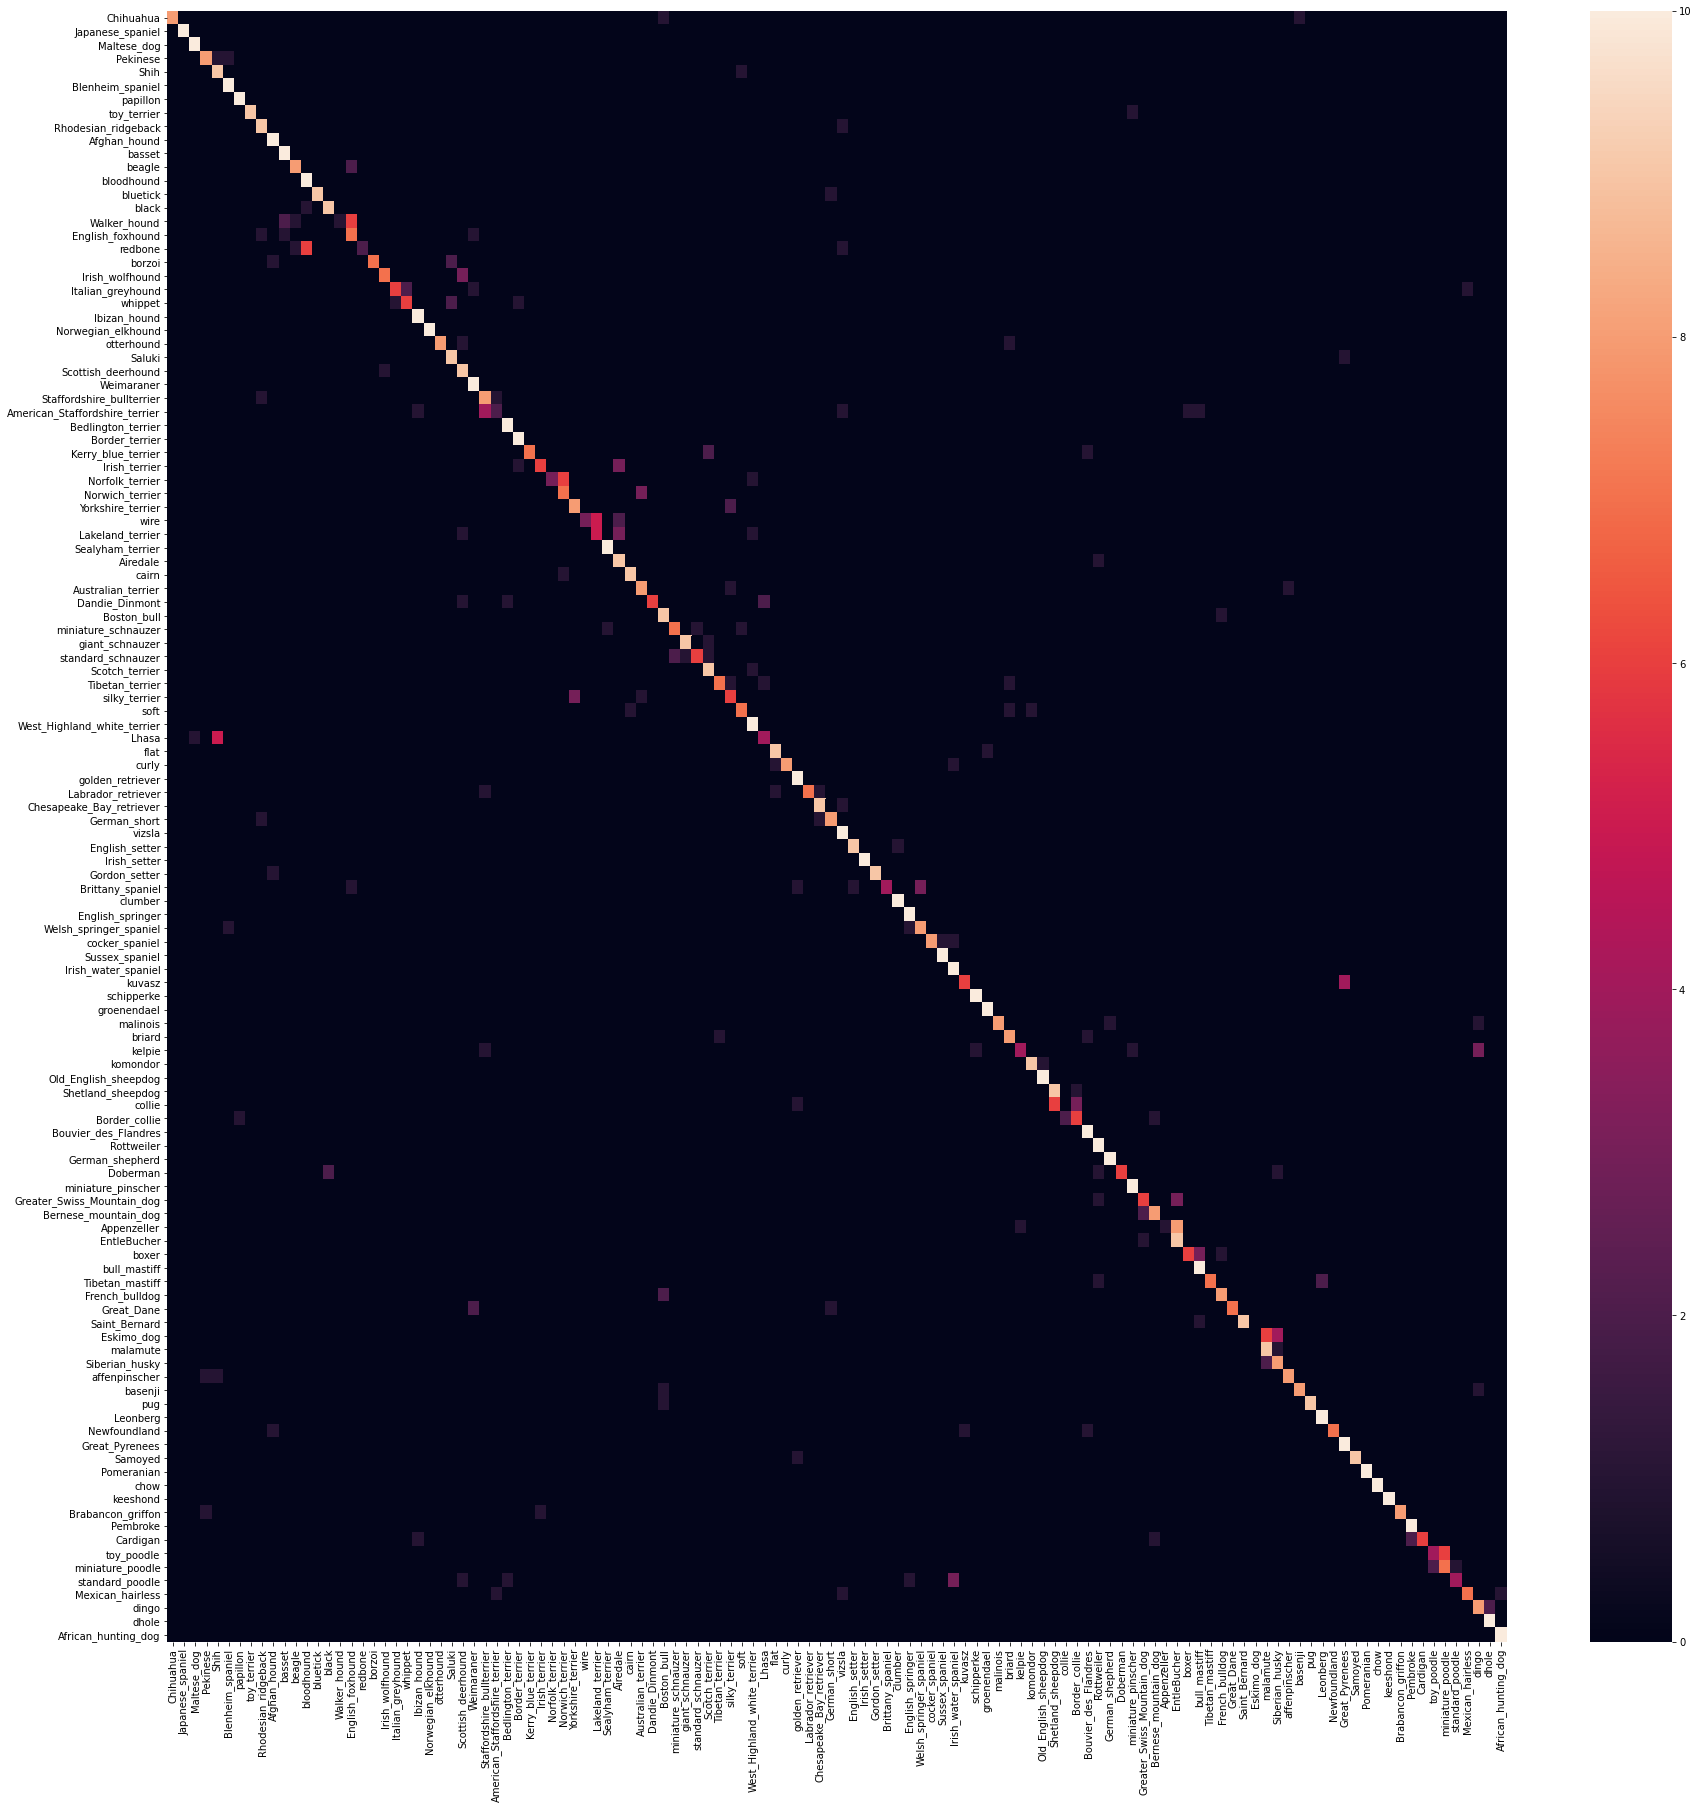

In [0]:
cm_inception = cm(inception_best)
df_cm = pd.DataFrame(cm_inception.numpy(), index = [i for i in my_class_names],
                  columns = [i for i in my_class_names])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm)
plt.savefig('confusion_matrix_inception')

In [0]:
torch.save(inception_best.state_dict(), 'inception_60')

In [0]:
inception = models.inception_v3()

inception.AuxLogits.fc = nn.Linear(768, 120)
inception.fc = nn.Linear(2048, 120)

inception.load_state_dict(torch.load('inception_60'))
inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

# Finally showing some test image results

In [0]:
from PIL import Image
from torch.autograd import Variable
imsize = 299
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

# image = image_loader('/content/images120_60_test/n02086240-Shih-Tzu/n02086240_1725.jpg')
# image = image_loader('/content/german_shepherd.jpg')

# outputs = inception_best(image)
# _, pred = torch.max(outputs, 1)
# print(my_class_names[pred])

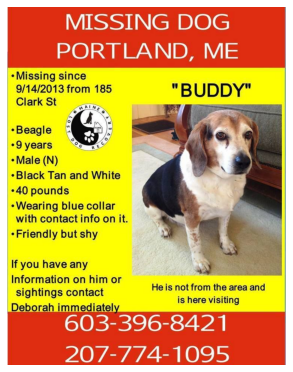

Predict as ---  beagle


In [0]:
# show image
image_name = '/content/beagle.jpg'
plt.figure(figsize=(5,10))
plt.imshow(Image.open(image_name))
plt.axis('off')
plt.show()

# prediction
image = image_loader(image_name)
outputs = inception_best(image)
_, pred = torch.max(outputs, 1)
print('Predict as --- ', my_class_names[pred])

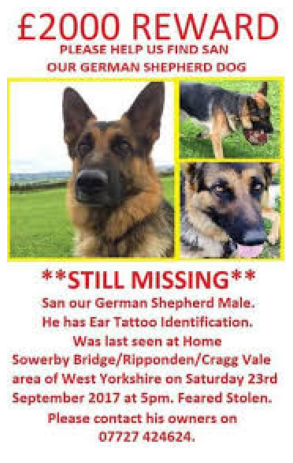

Predict as ---  German_shepherd


In [0]:
# show image
image_name = '/content/german_shepherd.jpg'
plt.figure(figsize=(5,10))
plt.imshow(Image.open(image_name))
plt.axis('off')
plt.show()

# prediction
image = image_loader(image_name)
outputs = inception_best(image)
_, pred = torch.max(outputs, 1)
print('Predict as --- ', my_class_names[pred])

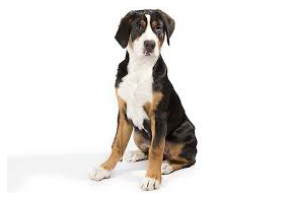

Predict as ---  Greater_Swiss_Mountain_dog


In [0]:
# show image
image_name = '/content/gsmd.jpg'
plt.figure(figsize=(5,10))
plt.imshow(Image.open(image_name))
plt.axis('off')
plt.show()

# prediction
image = image_loader(image_name)
outputs = inception_best(image)
_, pred = torch.max(outputs, 1)
print('Predict as --- ', my_class_names[pred])

In [0]:
class_names

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

In [0]:
with open('log/inception_60_0dot0001', 'r') as inFile:
  for line in inFile.readlines():
    print(line.split(' '))

['0', '0.8416', '0.0123', 'train\n']
['0', '0.5818', '0.0758', 'val\n']
['1', '0.8212', '0.0283', 'train\n']
['1', '0.5584', '0.2350', 'val\n']
['2', '0.8009', '0.0683', 'train\n']
['2', '0.5254', '0.4383', 'val\n']
['3', '0.7730', '0.1233', 'train\n']
['3', '0.4849', '0.5383', 'val\n']
['4', '0.7474', '0.1715', 'train\n']
['4', '0.4345', '0.6142', 'val\n']
['5', '0.7174', '0.2110', 'train\n']
['5', '0.3832', '0.6600', 'val\n']
['6', '0.6923', '0.2290', 'train\n']
['6', '0.3409', '0.6617', 'val\n']
['7', '0.6648', '0.2667', 'train\n']
['7', '0.2844', '0.7042', 'val\n']
['8', '0.6409', '0.2742', 'train\n']
['8', '0.2521', '0.7108', 'val\n']
['9', '0.6159', '0.3050', 'train\n']
['9', '0.2178', '0.7300', 'val\n']
['10', '0.5935', '0.3238', 'train\n']
['10', '0.1984', '0.7358', 'val\n']
['11', '0.5728', '0.3465', 'train\n']
['11', '0.1715', '0.7517', 'val\n']
['12', '0.5541', '0.3575', 'train\n']
['12', '0.1517', '0.7575', 'val\n']
['13', '0.5366', '0.3665', 'train\n']
['13', '0.1401', '0.

In [0]:
!zip -r log2.zip log

  adding: log/ (stored 0%)
  adding: log/resnet_40_0dot0001 (deflated 61%)
  adding: log/resnet_20_0dot001 (deflated 61%)
  adding: log/resnet_20_0dot0001 (deflated 61%)
  adding: log/.ipynb_checkpoints/ (stored 0%)
  adding: log/resnet_40_0dot001 (deflated 61%)
  adding: log/vgg_40_0dot0001 (deflated 62%)
  adding: log/inception_40_0dot0001 (deflated 60%)
  adding: log/vgg_20_0dot0001 (deflated 61%)
  adding: log/inception_20_0dot0001 (deflated 60%)
